In [46]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib.gridspec as gridspec
from importlib import reload
import plotting_utils
import os, sys
# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import my_stats

In [2]:
from dask.distributed import wait

In [3]:
import os

In [4]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=30, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/134238034.gadi-pbs/dask-scratch-space/scheduler-d22ujbx4', purging
 -   Scheduler at:     tcp://127.0.0.1:44959
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:41913'
 -         Start Nanny at: 'tcp://127.0.0.1:46649'
 -         Start Nanny at: 'tcp://127.0.0.1:32883'
 -         Start Nanny at: 'tcp://127.0.0.1:41489'
 -         Start Nanny at: 'tcp://127.0.0.1:45255'
 -         Start Nanny at: 'tcp://127.0.0.1:37521'
 -         Start Nanny at: 'tcp://127.0.0.1:46017'
 -         Start Nanny at: 'tcp://127.0.0.1:42149'
 -         Start Nanny at: 'tcp://127.0.0.1:38189'
 -         Start Nanny at: 'tcp://127.0.0.1:43653'
 -         Start Nanny at: 'tcp://127.0.0.1:43133'
 -         Start Nanny at: 'tcp://127.0.0.1:38797'
 -         Start Nanny at: 'tcp://127.0.0.1:43549'
 -         Start Nanny at: 'tcp://127.0.0.1:40619'
 -         Start Nanny at: 't

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 30
Total threads: 30,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44959,Workers: 30
Dashboard: /proxy/8787/status,Total threads: 30
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36943,Total threads: 1
Dashboard: /proxy/36907/status,Memory: 0 B
Nanny: tcp://127.0.0.1:41913,


In [5]:
MY_ERA5_PATH = '/g/data/w40/ab2313/time_of_emergence/era5/2t.zarr'

In [6]:
# Open all the files in the tmp file
my_data_ds = xr.open_zarr(MY_ERA5_PATH, use_cftime=True)['2t'].persist()

# Variability

## Calculations

In [7]:
my_data_ds

<xarray.DataArray '2t' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<open_dataset-2t, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) object 680B 1940-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes:
    save_chunks:  {'lat': 120, 'lon': 120, 'time': -1}

In [9]:
reload(my_stats)

<module 'my_stats' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/my_stats.py'>

In [10]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    my_data_ds,#.chunk({'time':-1, 'lat':10}), 
    kwargs={'window':41},
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
    output_dtypes=[np.float64]
).compute()

In [13]:
ds_detrend = (my_data_ds - ds_signal_lowess).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 673.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [14]:
start_var = ds_detrend.isel(time=slice(0, 30)).std(dim='time').compute()

In [15]:
end_var = ds_detrend.isel(time=slice(-30, None)).std(dim='time').compute()

In [16]:
var_div = end_var/start_var

## Plotting

In [17]:
var_levels = np.arange(0, 3, 0.25)
var_div_levels = np.arange(0, 3, 0.25)

In [18]:
upper_levels = np.array([1.25, 1.5, 1.75, 2, 2.5, 3, 4])
lower_levels = 1/upper_levels[::-1]

In [19]:
div_levels = np.unique(np.concatenate([lower_levels, [1], upper_levels]))

In [20]:
lower_labels = list(map(lambda x: f'1/{x}' if (x-int(x)) else f'1/{int(x)}', upper_levels[::-1]))
upper_labels = upper_levels.astype(str)
div_labels = np.concatenate([lower_labels, ['1'], upper_labels])

In [21]:
div_labels

array(['1/4', '1/3', '1/2.5', '1/2', '1/1.75', '1/1.5', '1/1.25', '1',
       '1.25', '1.5', '1.75', '2.0', '2.5', '3.0', '4.0'], dtype='<U32')

In [22]:
div_levels

array([0.25      , 0.33333333, 0.4       , 0.5       , 0.57142857,
       0.66666667, 0.8       , 1.        , 1.25      , 1.5       ,
       1.75      , 2.        , 2.5       , 3.        , 4.        ])

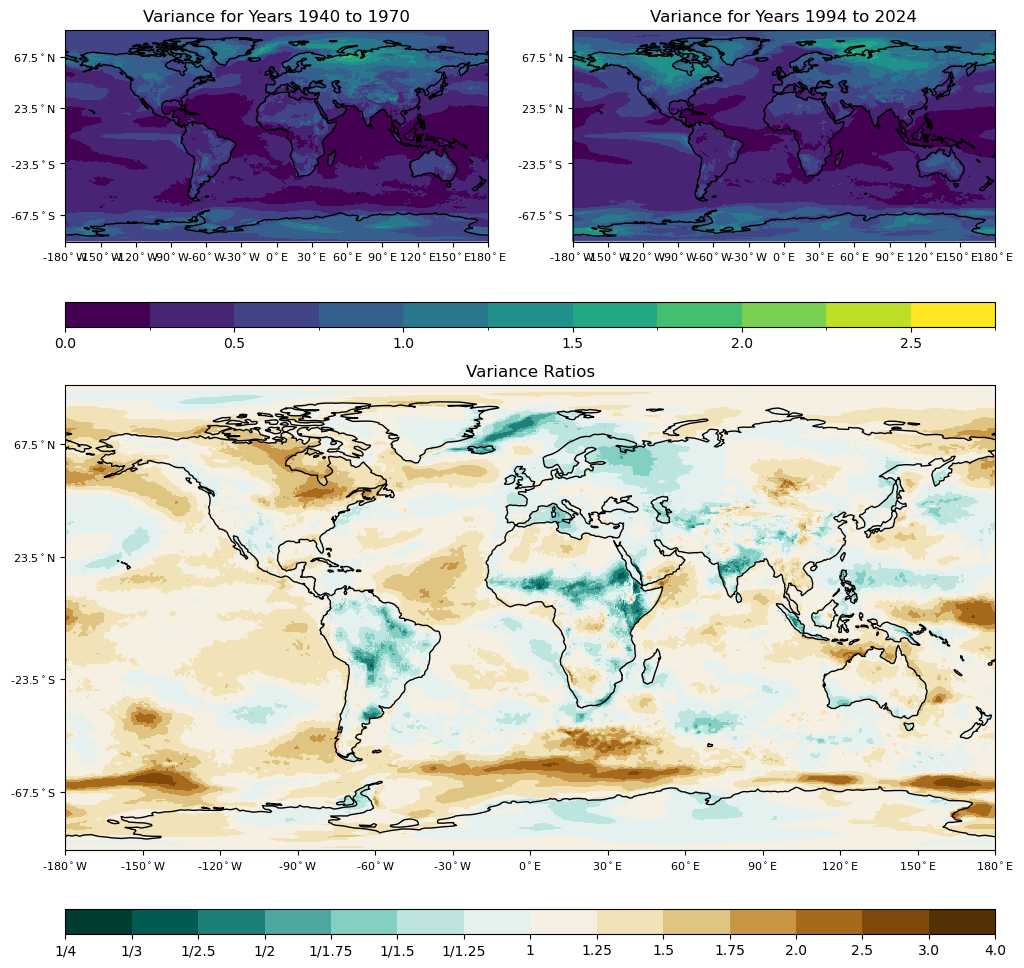

In [71]:
fig = plt.figure(figsize=(12, 12))

gs = gridspec.GridSpec(4,2, height_ratios=[0.5, 0.05, 1, 0.05])
axes_small = [fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree()) for i in range(2)]
ax_big = fig.add_subplot(gs[2, :], projection=ccrs.PlateCarree())

axes = np.concatenate([axes_small, [ax_big]])

start_var.plot(ax=axes[0], levels=var_levels, add_colorbar=False)
var_plot = end_var.plot(ax=axes[1], levels=var_levels, add_colorbar=False)
div_plot = var_div.plot(ax=axes[2], levels=div_levels, cmap='BrBG_r',
                        add_colorbar=False)
[ax.coastlines() for ax in axes]
[plotting_utils.add_lat_lon_markers(ax) for ax in axes]
# [plotting_utils.add_lon_markers(ax) for ax in axes]


axes[0].set_title('Variance for Years 1940 to 1970')
axes[1].set_title('Variance for Years 1994 to 2024')
axes[2].set_title('Variance Ratios')


cax1 = plt.subplot(gs[1, :])
cax2 = plt.subplot(gs[3, :])

plt.colorbar(var_plot, cax=cax1, orientation='horizontal')
cbar = plt.colorbar(div_plot, cax=cax2, orientation='horizontal')
cbar.set_ticks(div_levels)
cbar.set_ticklabels(div_labels)

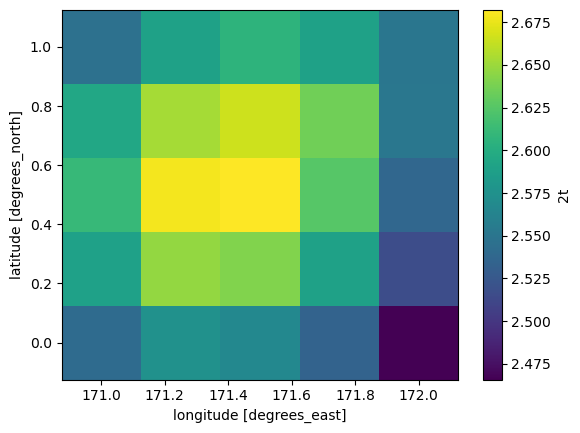

In [85]:
var_div.sortby('lat').sel(lat=slice(0,1), lon=slice(171, 172)).plot()

In [30]:
stacked = var_div.stack(latlon=('lat', 'lon')).dropna(dim='latlon')
sorted_stacked = stacked.sortby(stacked, ascending=True)

In [31]:
sorted_stacked

<xarray.DataArray '2t' (latlon: 1038240)> Size: 8MB
array([0.28404222, 0.30142256, 0.30706377, ..., 2.98640252, 2.99497503,
       3.00026379])
Coordinates:
  * latlon   (latlon) object 8MB MultiIndex
  * lat      (latlon) float32 4MB 12.0 12.25 12.5 17.0 ... -62.0 -62.0 -62.0
  * lon      (latlon) float32 4MB 40.5 40.5 40.5 42.75 ... -145.5 -145.8 -146.8

In [41]:
sorted_stacked.isel(latlon=slice(30, 40)).latlon.values # Smallest

array([(19.25, 41.75), (12.25, 4.25), (12.25, 40.0), (11.75, 4.0),
       (12.25, 41.0), (12.0, 4.0), (19.75, 41.25), (12.25, 4.0),
       (12.5, 41.0), (13.0, 40.75)], dtype=object)

In [64]:
# sorted_stacked.isel(latlon=slice(-300, -10)).latlon.values # Largest

In [59]:
loc = dict(lat=12.25, lon=4, method='nearest') # Smallest var change (best)

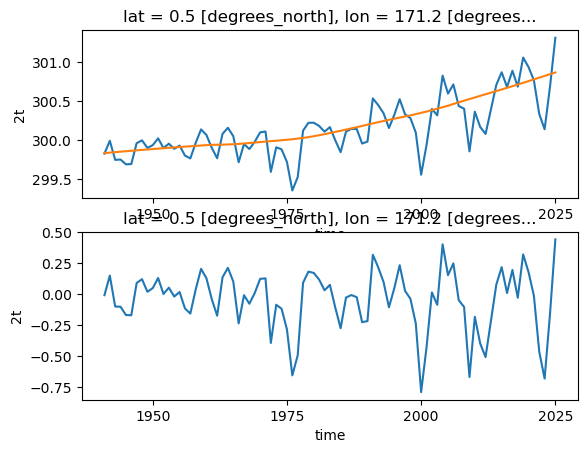

In [90]:
# loc = dict(lat=-1.5, lon=133.5, method='nearest') # Largest var change
# loc = dict(lat=-1.5, lon=133.5, method='nearest') # Largest var change
# loc = dict(lat=12, lon=40.5, method='nearest') # Smallest var change
# loc = dict(lat=12.25, lon=4, method='nearest') # Smallest var change
# loc = dict(lat=46.1914, lon=22.1956, method='nearest') # mt st helens
loc = dict(lat=0.5, lon=171.2, method='nearest')

fig, (ax1, ax2) = plt.subplots(2, 1)

my_data_ds.sel(**loc).plot(ax=ax1)
ds_signal_lowess.sel(**loc).plot(ax=ax1)
ds_detrend.sel(**loc).plot(ax=ax2)

# ds_detrend.sel(**loc).rolling(time=30, min_periods=20).std().plot()

In [28]:
sorted_stacked.isel(latlon=-1)

<xarray.DataArray '2t' ()> Size: 8B
array(3.00026379)
Coordinates:
    latlon   object 8B (-62.0, -146.75)
    lat      float32 4B -62.0
    lon      float32 4B -146.8

In [29]:
sorted_stacked.isel(latlon=slice(-30, None)).latlon.values

array([(-62.75, -146.5), (-62.0, -145.0), (-62.5, -147.0),
       (-62.25, -146.75), (-61.75, -146.5), (-61.75, -147.0),
       (-62.5, -146.0), (-62.5, -145.75), (-62.25, -146.25),
       (-62.25, -145.5), (-61.75, -146.25), (-61.75, -146.75),
       (-62.75, -146.75), (-62.25, -146.0), (-62.0, -147.0),
       (-61.75, -145.5), (-62.0, -145.25), (-62.25, -145.75),
       (-61.75, -146.0), (-62.25, -146.5), (-62.5, -146.25),
       (-62.5, -146.75), (-62.5, -146.5), (-61.75, -145.75),
       (-62.0, -146.5), (-62.0, -146.25), (-62.0, -146.0),
       (-62.0, -145.5), (-62.0, -145.75), (-62.0, -146.75)], dtype=object)

# Comparing with Their Data

In [10]:
THEIR_ERA5_PATH = '/g/data/rt52/era5/single-levels/monthly-averaged/2t'

In [11]:
their_data_ds = xr.open_mfdataset(THEIR_ERA5_PATH + '/**/*.nc', use_cftime=True).persist()

In [24]:
their_data_ds = their_data_ds.resample(time='YE').mean().persist()
wait(their_data_ds)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 6.10 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


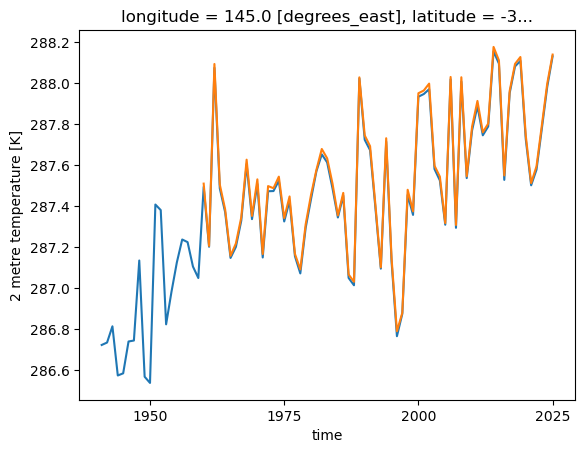

In [28]:
my_data_ds.sel(lat=-39, lon=145, method='nearest')['2t'].plot()
their_data_ds.sel(latitude=-39, longitude=145, method='nearest').t2m.plot()